In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight


In [2]:
df = pd.read_csv('data_science_job.csv', 
                 encoding='latin1')

In [3]:
df

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,NaN,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,"
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,"
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi..."
...,...,...,...,...,...,...,...,...
3193,Western Digital,Data Scientist - New College Graduate,"Biñan, Philippines",Full Time,Entry-level,39K+ *,"APIs,Clustering,Computer Science,Data visualiz...","Career development,,,,"
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",Full Time,Senior-level,92K+ *,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,,"
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",Full Time,Senior-level,62K+ *,"E-commerce,Engineering,Linux,Python,Robotics,S...",",,,,"
3196,ATB Financial,Data Scientist,"Edmonton, Alberta, Canada",Full Time,Entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Ec...","Career development,Startup environment,,,"


In [4]:
print(df.shape)
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())

(3198, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company                     3197 non-null   object
 1   Job Title                   3197 non-null   object
 2   Location                    3197 non-null   object
 3   Job Type                    3197 non-null   object
 4   Experience level            2962 non-null   object
 5   Salary                      3009 non-null   object
 6   Requirment of the company   3198 non-null   object
 7   Facilities                  3198 non-null   object
dtypes: object(8)
memory usage: 200.0+ KB
None
                Company      Job Title          Location   Job Type  \
count              3197           3197              3197       3197   
unique             1106           2138              1117          3   
top     Publicis Groupe  Data Engineer  Bengaluru, India  Full T

In [5]:
# Strip whitespace dari kolom string
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda col: col.str.strip())

# Bersihkan kolom Salary: buang simbol, konversi ke numerik (ambil nilai minimum)
df['Salary_clean'] = df['Salary'].apply(lambda x: float(re.findall(r'\d+', x.replace(',', ''))[0]) if pd.notnull(x) else np.nan)

# Ubah Experience level jadi lowercase & standardize
df['Experience level'] = df['Experience level'].str.lower().str.strip()

# Isi missing Experience level dengan 'unknown'
df['Experience level'] = df['Experience level'].fillna('unknown')

In [6]:
print(df.shape)
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())

(3198, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Company                     3197 non-null   object 
 1   Job Title                   3197 non-null   object 
 2   Location                    3197 non-null   object 
 3   Job Type                    3197 non-null   object 
 4   Experience level            3198 non-null   object 
 5   Salary                      3009 non-null   object 
 6   Requirment of the company   3198 non-null   object 
 7   Facilities                  3198 non-null   object 
 8   Salary_clean                3009 non-null   float64
dtypes: float64(1), object(8)
memory usage: 225.0+ KB
None
                Company      Job Title          Location   Job Type  \
count              3197           3197              3197       3197   
unique             1106           2138              1116

In [7]:
print(df.describe(include=[np.number]))
print(df.describe(include=[object]))

       Salary_clean
count   3009.000000
mean      90.241276
std       42.689763
min       30.000000
25%       56.000000
50%       77.000000
75%      115.000000
max      315.000000
                Company      Job Title          Location   Job Type  \
count              3197           3197              3197       3197   
unique             1106           2138              1116          3   
top     Publicis Groupe  Data Engineer  Bengaluru, India  Full Time   
freq                126            105                90       3116   

       Experience level   Salary  \
count              3198     3009   
unique                5      218   
top        senior-level  115K+ *   
freq               1876      253   

                               Requirment of the company  Facilities  
count                                                3198       3198  
unique                                               2600        777  
top     Big Data,Business Intelligence,Data analysis,E...       ,,,,  

In [8]:
df['Facilities_list'] = df['Facilities'].apply(lambda x: [f.strip() for f in str(x).split(',') if f.strip()])
df['Country'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notnull(x) else 'unknown')

In [9]:
df['Num_facilities'] = df['Facilities_list'].apply(len)
df

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,Salary_clean,Facilities_list,Country,Num_facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,",48.0,[],United States,0
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,",48.0,[],Mauritius,0
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,unknown,90K+ *,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,",90.0,[Career development],United States,1
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,",48.0,[],Italy,0
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi...",108.0,"[Flex hours, Flex vacation, Parental leave, Un...",United States,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3193,Western Digital,Data Scientist - New College Graduate,"Biñan, Philippines",Full Time,entry-level,39K+ *,"APIs,Clustering,Computer Science,Data visualiz...","Career development,,,,",39.0,[Career development],Philippines,1
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",Full Time,senior-level,92K+ *,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,,",92.0,"[Equity, Medical leave, Salary bonus]",Costa Rica,3
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",Full Time,senior-level,62K+ *,"E-commerce,Engineering,Linux,Python,Robotics,S...",",,,,",62.0,[],United States,0
3196,ATB Financial,Data Scientist,"Edmonton, Alberta, Canada",Full Time,entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Ec...","Career development,Startup environment,,,",39.0,"[Career development, Startup environment]",Canada,2


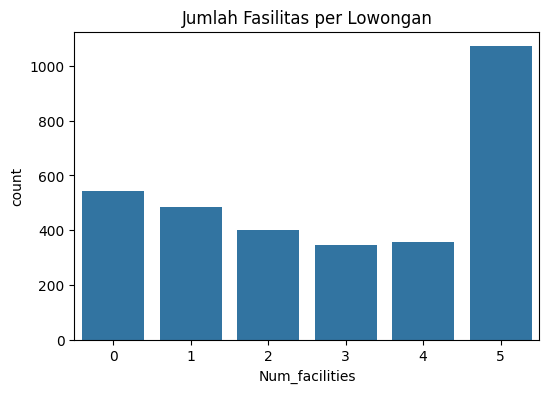

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='Num_facilities', data=df, order=sorted(df['Num_facilities'].unique()))
plt.title('Jumlah Fasilitas per Lowongan')
plt.show()

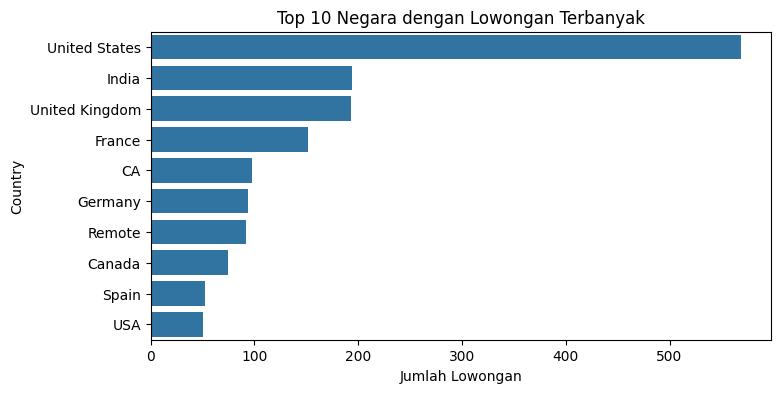

In [11]:
top_countries = df['Country'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title('Top 10 Negara dengan Lowongan Terbanyak')
plt.xlabel('Jumlah Lowongan')
plt.show()

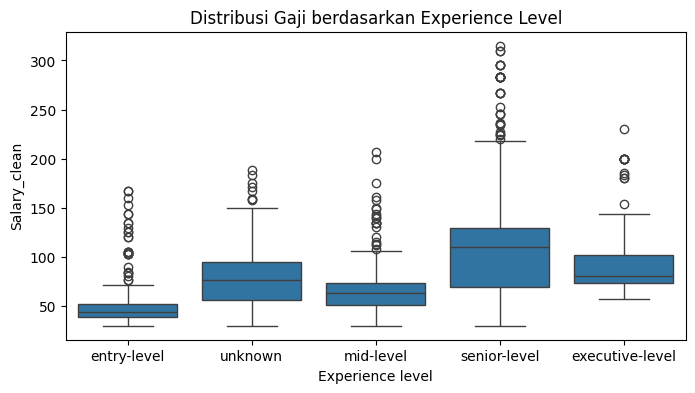

In [12]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Experience level', y='Salary_clean', data=df)
plt.title('Distribusi Gaji berdasarkan Experience Level')
plt.show()

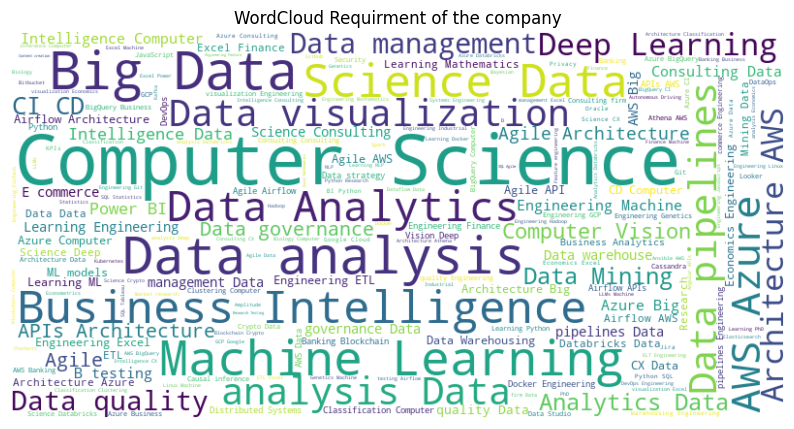

In [13]:
all_reqs = ' '.join(df['Requirment of the company '].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reqs)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Requirment of the company')
plt.show()

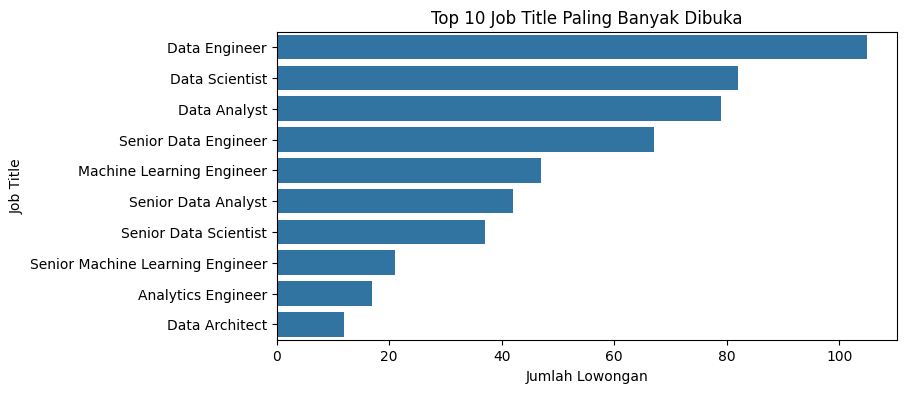

In [14]:
top_jobs = df['Job Title'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(y=top_jobs.index, x=top_jobs.values)
plt.title('Top 10 Job Title Paling Banyak Dibuka')
plt.xlabel('Jumlah Lowongan')
plt.show()

In [15]:
df = df[df['Experience level'] != 'unknown']
df['Experience level'] = df['Experience level'].str.lower().str.strip()
df

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\1177847506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Experience level'] = df['Experience level'].str.lower().str.strip()


,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,Salary_clean,Facilities_list,Country,Num_facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,",48.0,[],United States,0
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,",48.0,[],Mauritius,0
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,",48.0,[],Italy,0
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi...",108.0,"[Flex hours, Flex vacation, Parental leave, Un...",United States,4
5,ServiceNow,Sr Staff Data Scientist - ATG,"Kirkland, Washington, United States",Full Time,senior-level,184K+,"Computer Science,Deep Learning,Industrial,Mach...","401(k) matching,Career development,Competitive...",184.0,"[401(k) matching, Career development, Competit...",United States,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3193,Western Digital,Data Scientist - New College Graduate,"Biñan, Philippines",Full Time,entry-level,39K+ *,"APIs,Clustering,Computer Science,Data visualiz...","Career development,,,,",39.0,[Career development],Philippines,1
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",Full Time,senior-level,92K+ *,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,,",92.0,"[Equity, Medical leave, Salary bonus]",Costa Rica,3
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",Full Time,senior-level,62K+ *,"E-commerce,Engineering,Linux,Python,Robotics,S...",",,,,",62.0,[],United States,0
3196,ATB Financial,Data Scientist,"Edmonton, Alberta, Canada",Full Time,entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Ec...","Career development,Startup environment,,,",39.0,"[Career development, Startup environment]",Canada,2


In [16]:
df['Country'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notnull(x) else 'unknown')
df['Num_facilities'] = df['Facilities'].apply(lambda x: len([f for f in str(x).split(',') if f.strip()]))
df

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\2593627377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'] = df['Location'].apply(lambda x: x.split(',')[-1].strip() if pd.notnull(x) else 'unknown')
C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\2593627377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Num_facilities'] = df['Facilities'].apply(lambda x: len([f for f in str(x).split(',') if f.strip()]))


,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,Salary_clean,Facilities_list,Country,Num_facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,",48.0,[],United States,0
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,",48.0,[],Mauritius,0
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,",48.0,[],Italy,0
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi...",108.0,"[Flex hours, Flex vacation, Parental leave, Un...",United States,4
5,ServiceNow,Sr Staff Data Scientist - ATG,"Kirkland, Washington, United States",Full Time,senior-level,184K+,"Computer Science,Deep Learning,Industrial,Mach...","401(k) matching,Career development,Competitive...",184.0,"[401(k) matching, Career development, Competit...",United States,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3193,Western Digital,Data Scientist - New College Graduate,"Biñan, Philippines",Full Time,entry-level,39K+ *,"APIs,Clustering,Computer Science,Data visualiz...","Career development,,,,",39.0,[Career development],Philippines,1
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",Full Time,senior-level,92K+ *,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,,",92.0,"[Equity, Medical leave, Salary bonus]",Costa Rica,3
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",Full Time,senior-level,62K+ *,"E-commerce,Engineering,Linux,Python,Robotics,S...",",,,,",62.0,[],United States,0
3196,ATB Financial,Data Scientist,"Edmonton, Alberta, Canada",Full Time,entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Ec...","Career development,Startup environment,,,",39.0,"[Career development, Startup environment]",Canada,2


In [17]:
df['Salary_clean'] = df['Salary_clean'].fillna(df['Salary_clean'].median())
df

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\2389946448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Salary_clean'] = df['Salary_clean'].fillna(df['Salary_clean'].median())


,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,Salary_clean,Facilities_list,Country,Num_facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,",48.0,[],United States,0
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,",48.0,[],Mauritius,0
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,",48.0,[],Italy,0
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi...",108.0,"[Flex hours, Flex vacation, Parental leave, Un...",United States,4
5,ServiceNow,Sr Staff Data Scientist - ATG,"Kirkland, Washington, United States",Full Time,senior-level,184K+,"Computer Science,Deep Learning,Industrial,Mach...","401(k) matching,Career development,Competitive...",184.0,"[401(k) matching, Career development, Competit...",United States,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3193,Western Digital,Data Scientist - New College Graduate,"Biñan, Philippines",Full Time,entry-level,39K+ *,"APIs,Clustering,Computer Science,Data visualiz...","Career development,,,,",39.0,[Career development],Philippines,1
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",Full Time,senior-level,92K+ *,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,,",92.0,"[Equity, Medical leave, Salary bonus]",Costa Rica,3
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",Full Time,senior-level,62K+ *,"E-commerce,Engineering,Linux,Python,Robotics,S...",",,,,",62.0,[],United States,0
3196,ATB Financial,Data Scientist,"Edmonton, Alberta, Canada",Full Time,entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Ec...","Career development,Startup environment,,,",39.0,"[Career development, Startup environment]",Canada,2


In [18]:
for col in ['Company', 'Country']:
    freq = df[col].value_counts() / len(df)
    df[f'{col}_freq'] = df[col].map(freq)

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\1669321341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_freq'] = df[col].map(freq)
C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\1669321341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_freq'] = df[col].map(freq)


In [19]:
df['JobTitle_len'] = df['Job Title'].astype(str).apply(len)
df['Req_words_count'] = df['Requirment of the company '].astype(str).apply(lambda x: len(x.split(',')))
df['Num_facilities'] = df['Facilities_list'].apply(len)

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\837788855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['JobTitle_len'] = df['Job Title'].astype(str).apply(len)
C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\837788855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Req_words_count'] = df['Requirment of the company '].astype(str).apply(lambda x: len(x.split(',')))
C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\837788855.py:3: SettingWithCopyWarn

In [20]:
df['mean_salary_by_country'] = df.groupby('Country')['Salary_clean'].transform('mean')
df['mean_salary_by_company'] = df.groupby('Company')['Salary_clean'].transform('mean')

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\431285202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_salary_by_country'] = df.groupby('Country')['Salary_clean'].transform('mean')
C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\431285202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean_salary_by_company'] = df.groupby('Company')['Salary_clean'].transform('mean')


In [21]:
df['salary_minus_country_mean'] = df['Salary_clean'] - df['mean_salary_by_country']
df['salary_minus_company_mean'] = df['Salary_clean'] - df['mean_salary_by_company']

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\1929730224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['salary_minus_country_mean'] = df['Salary_clean'] - df['mean_salary_by_country']
C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_7180\1929730224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['salary_minus_company_mean'] = df['Salary_clean'] - df['mean_salary_by_company']


In [22]:
df = pd.get_dummies(df, columns=['Job Type'], drop_first=True)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [24]:
# Job Title
tfidf = TfidfVectorizer(max_features=100)
jobtitle_tfidf = tfidf.fit_transform(df['Job Title'].astype(str))

svd = TruncatedSVD(n_components=5, random_state=42)
jobtitle_svd = svd.fit_transform(jobtitle_tfidf)

# Add to df
for i in range(5):
    df[f'jobtitle_svd_{i}'] = jobtitle_svd[:, i]

In [25]:
for col in ['Company', 'Country']:
    grp = df.groupby(col)['Salary_clean']
    df[f'{col}_std_salary'] = df[col].map(grp.std())
    df[f'{col}_min_salary'] = df[col].map(grp.min())
    df[f'{col}_max_salary'] = df[col].map(grp.max())
    df[f'{col}_count'] = df[col].map(grp.count())

In [26]:
df['salary_div_country_mean'] = df['Salary_clean'] / (df['mean_salary_by_country'] + 1e-3)
df['salary_div_company_mean'] = df['Salary_clean'] / (df['mean_salary_by_company'] + 1e-3)

In [27]:
df['company_freq_x_mean_salary'] = df['Company_freq'] * df['mean_salary_by_company']
df['country_freq_x_mean_salary'] = df['Country_freq'] * df['mean_salary_by_country']

In [28]:
keywords = ['Python', 'AWS', 'SQL', 'Machine Learning', 'Deep Learning']
for kw in keywords:
    df[f'req_has_{kw.lower().replace(" ", "_")}'] = df['Requirment of the company '].astype(str).apply(lambda x: int(kw.lower() in x.lower()))

In [29]:
df['salary_rank_country'] = df.groupby('Country')['Salary_clean'].rank(pct=True)
df['salary_rank_company'] = df.groupby('Company')['Salary_clean'].rank(pct=True)

In [30]:
df['salary_bin'] = pd.qcut(df['Salary_clean'], q=5, duplicates='drop', labels=False)

In [31]:
df['has_career_development'] = df['Facilities_list'].apply(lambda x: int('Career development' in x))
df['num_facilities'] = df['Facilities_list'].apply(len)

In [32]:
df

,Company,Job Title,Location,Experience level,Salary,Requirment of the company,Facilities,Salary_clean,Facilities_list,Country,...,req_has_python,req_has_aws,req_has_sql,req_has_machine_learning,req_has_deep_learning,salary_rank_country,salary_rank_company,salary_bin,has_career_development,num_facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathema...",",,,,",48.0,[],United States,...,0,0,0,0,0,0.068519,0.500000,0,0,0
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,",48.0,[],Mauritius,...,0,0,0,0,0,0.500000,0.500000,0,0,0
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",entry-level,48K+ *,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,",48.0,[],Italy,...,0,0,0,0,0,0.444444,0.222222,0,0,0
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",mid-level,108K+,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi...",108.0,"[Flex hours, Flex vacation, Parental leave, Un...",United States,...,0,1,0,0,0,0.533333,0.756522,3,0,4
5,ServiceNow,Sr Staff Data Scientist - ATG,"Kirkland, Washington, United States",senior-level,184K+,"Computer Science,Deep Learning,Industrial,Mach...","401(k) matching,Career development,Competitive...",184.0,"[401(k) matching, Career development, Competit...",United States,...,0,0,0,1,1,0.908333,0.916667,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3193,Western Digital,Data Scientist - New College Graduate,"Biñan, Philippines",entry-level,39K+ *,"APIs,Clustering,Computer Science,Data visualiz...","Career development,,,,",39.0,[Career development],Philippines,...,0,0,0,0,1,0.250000,0.333333,0,1,1
3194,Experian,Cloud Data Analyst,"Heredia, Costa Rica",senior-level,92K+ *,"AWS,Big Data,Computer Science,GCP,Snowflake,SQL","Equity,Medical leave,Salary bonus,,",92.0,"[Equity, Medical leave, Salary bonus]",Costa Rica,...,0,1,1,0,0,0.550000,0.732143,2,0,3
3195,Locus Robotics,"Robotics Engineer, Sensors","Wilmington, MA, United States",senior-level,62K+ *,"E-commerce,Engineering,Linux,Python,Robotics,S...",",,,,",62.0,[],United States,...,1,0,0,0,0,0.179630,0.500000,1,0,0
3196,ATB Financial,Data Scientist,"Edmonton, Alberta, Canada",entry-level,39K+ *,"Computer Science,Data Analytics,Data Mining,Ec...","Career development,Startup environment,,,",39.0,"[Career development, Startup environment]",Canada,...,0,0,0,0,0,0.014706,0.500000,0,1,2


In [33]:
drop_cols = [
    'Job Title'
    'Location', 'Salary', 'Requirment of the company',
    'Facilities', 'Facilities_list', 'Country'
]

In [34]:
le_company = LabelEncoder()
df['Company_encoded'] = le_company.fit_transform(df['Company'].astype(str))

In [35]:
feature_cols = [
    'Company_encoded',
    'Salary_clean',
    'mean_salary_by_company', 'salary_minus_country_mean', 'salary_minus_company_mean',
    'Job Type_Internship', 'Job Type_Part Time',
    'req_has_python', 'req_has_aws', 'req_has_sql', 'req_has_machine_learning', 'req_has_deep_learning',
    'salary_rank_country', 'salary_rank_company', 'salary_bin', 'has_career_development', 'num_facilities',
    'jobtitle_svd_0', 'jobtitle_svd_1', 'jobtitle_svd_2', 'jobtitle_svd_3', 'jobtitle_svd_4'
]

X = df[feature_cols]
y = df['Experience level']

In [36]:
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [38]:
from sklearn.utils.class_weight import compute_sample_weight

In [39]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [39]:
clf = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)

In [39]:
clf.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=10

In [39]:
y_pred = clf.predict(X_test)

print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(
    y_test, y_pred, target_names=le_target.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [55]:
# Ambil feature importance dari model
importance = clf.feature_importances_

# Buat dataframe agar mudah dibaca
feat_imp = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values(by='importance', ascending=False)

print("=== Feature Importance ===")
print(feat_imp)


=== Feature Importance ===
                      feature  importance
5         Job Type_Internship    0.331399
14                 salary_bin    0.145630
6          Job Type_Part Time    0.075332
1                Salary_clean    0.073374
9                 req_has_sql    0.040996
19             jobtitle_svd_2    0.030966
21             jobtitle_svd_4    0.026820
4   salary_minus_company_mean    0.025342
11      req_has_deep_learning    0.024659
17             jobtitle_svd_0    0.024493
18             jobtitle_svd_1    0.023297
2      mean_salary_by_company    0.022339
20             jobtitle_svd_3    0.018625
13        salary_rank_company    0.018552
7              req_has_python    0.017666
8                 req_has_aws    0.017291
12        salary_rank_country    0.017027
3   salary_minus_country_mean    0.015411
16             num_facilities    0.013502
10   req_has_machine_learning    0.013372
15     has_career_development    0.012758
0             Company_encoded    0.011150


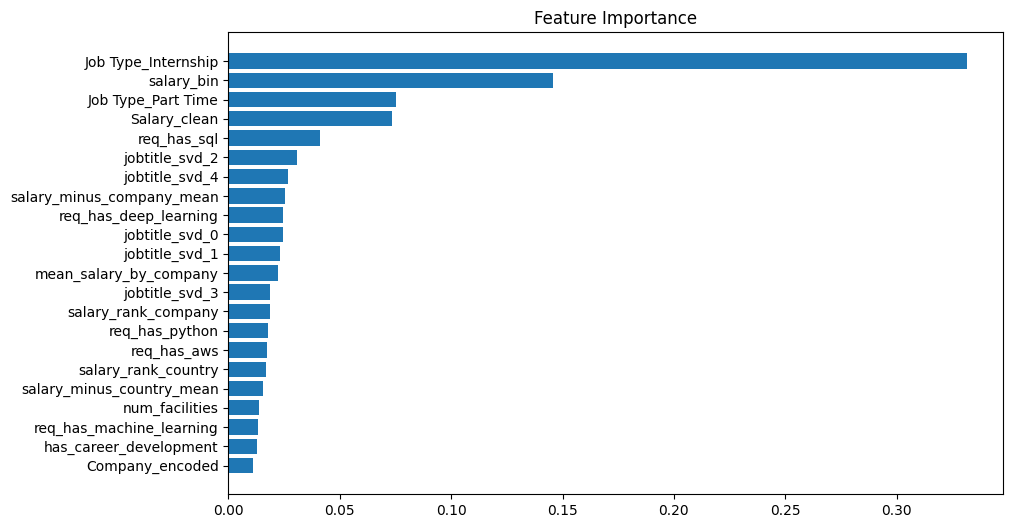

In [56]:
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title('Feature Importance')
plt.show()


In [217]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [284]:
threshold = 0.0127
selected_features = feat_imp[feat_imp['importance'] >= threshold]['feature'].tolist()

print(f"\n✅ Selected features (len={len(selected_features)}):\n{selected_features}")


✅ Selected features (len=21):
['Job Type_Internship', 'salary_bin', 'Job Type_Part Time', 'Salary_clean', 'req_has_sql', 'jobtitle_svd_2', 'jobtitle_svd_4', 'salary_minus_company_mean', 'req_has_deep_learning', 'jobtitle_svd_0', 'jobtitle_svd_1', 'mean_salary_by_company', 'jobtitle_svd_3', 'salary_rank_company', 'req_has_python', 'req_has_aws', 'salary_rank_country', 'salary_minus_country_mean', 'num_facilities', 'req_has_machine_learning', 'has_career_development']


In [285]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)
    ]
)

In [286]:
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_target.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    booster='dart',         # 🧪 Eksperimen: 'gbtree' (default), 'dart', 'gblinear'
    reg_alpha=0.1,         # ✅ Regularization L1
    reg_lambda=1.0,        # ✅ Regularization L2
    class_weight='balanced', # kalau imbalance
    random_state=42
)

In [287]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

In [288]:
pipeline.fit(X_train[selected_features], y_train)

C:\Users\I Putu Nanda Aditya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:27:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Job Type_Internship',
                                                   'salary_bin',
                                                   'Job Type_Part Time',
                                                   'Salary_clean',
                                                   'req_has_sql',
                                                   'jobtitle_svd_2',
                                                   'jobtitle_svd_4',
                                                   'salary_minus_company_mean',
                                                   'req_has_deep_learning',
                                                   'jobtitle_svd_0',
                                                   'jobtitle_svd_1',
                                                   'mean_salary_by_company',
                                                   'jobtitle_svd_3',
                                                   'salary_rank_comp...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, ...))])

In [289]:
y_pred = pipeline.predict(X_test[selected_features])

print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Accuracy: 0.9005059021922428

=== Classification Report ===
                 precision    recall  f1-score   support

    entry-level       0.91      0.87      0.89       101
executive-level       0.72      0.50      0.59        26
      mid-level       0.87      0.81      0.84        90
   senior-level       0.91      0.96      0.94       376

       accuracy                           0.90       593
      macro avg       0.85      0.78      0.81       593
   weighted avg       0.90      0.90      0.90       593


✅ Confusion Matrix:
 [[ 88   1   3   9]
 [  0  13   1  12]
 [  2   2  73  13]
 [  7   2   7 360]]
